In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import pickle
xgb.set_config(verbosity=1) #turn down info

from sklearn import tree
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import confusion_matrix
import itertools

## training set, validation set, testing set

In [2]:

#train_set.drop(train_set[:10000].loc[train_set['TARGET']==0].index, inplace=True)
#train_set.drop(train_set[-10000:].loc[train_set['TARGET']==0].index, inplace=True)
train_set = pd.read_csv('train_set_V.csv')[:1000000]
valid_set = pd.read_csv('val_set_V.csv')[:10000]
test_set = pd.read_csv('test_set_V.csv')[:10000]

In [3]:
train_set.tail(20)

,AGE,HAS_AE,HAS_AW,HAS_IP,LOGICAL_FACTOR_1,LOGICAL_FACTOR_2,SEX_K,SEX_M,SEX_N,NATIONALITY_0,...,PKD_GROUP_90,PKD_GROUP_91,PKD_GROUP_93,PKD_GROUP_95,PKD_GROUP_96,PKD_GROUP_97,PKD_GROUP_98,PKD_GROUP_99,PKD_GROUP_na,TARGET
999980,-1.140551,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
999981,-0.056975,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999982,1.055820,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
999983,0.220737,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
999984,-0.595702,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999985,-1.556284,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
999986,0.233259,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999987,-0.426793,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999988,-0.845030,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
999989,1.209424,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = np.array(train_set['TARGET'])
x_train = np.array(train_set.drop(['TARGET'], axis=1))

y_val = np.array(valid_set['TARGET'])
x_val = np.array(valid_set.drop(['TARGET'], axis=1))

y_test = np.array(test_set['TARGET'])
x_test = np.array(test_set.drop(['TARGET'], axis=1))

In [5]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1000000, 202) (1000000,)
(10000, 202) (10000,)
(10000, 202) (10000,)


# Bagging on decision trees:

In [6]:
def create_bootstrap_data():
    bootstrap_ids = np.random.randint(0, len(x_train), size=len(x_train))
    return x_train[bootstrap_ids,:], y_train[bootstrap_ids]

In [7]:
def build_classifier(data_set, labels, max_depth):
    random_state= np.random.randint(low=0, high=1e5)
    decision_tree = tree.DecisionTreeClassifier(max_depth = max_depth, random_state=random_state)
    decision_tree.fit(data_set, labels)
    return decision_tree

In [8]:
def build_classifiers(cases, max_depth):
    classifiers = []
    for case in range(cases):
        bootstrap_set, bootstrap_labels = create_bootstrap_data()
        classifier = build_classifier(bootstrap_set, bootstrap_labels, max_depth)
        classifiers.append(classifier)
    return classifiers

In [9]:
def vote(classifiers, test_data):
    output = []
    for classifier in classifiers:
        output.append(classifier.predict(test_data))
    output = np.array(output)
    predicted = []
    for i in range(len(test_data)):
        classified = output[:, i]
        counts = np.bincount(classified)
        predicted.append(np.argmax(counts))
    return predicted

## Grid search:

m_arr = np.arange(10, 30, 4)
depth_arr = np.linspace(10,40, 5).astype(int)
for m in m_arr:
    for max_depth in depth_arr:
        classifiers = build_classifiers(m, max_depth)
        predicted = vote(classifiers, x_val)
        accuracy = accuracy_score(y_val, predicted)
        print("Accuracy on validation set: {:.2f} using m={:} and depth = {:}".format(accuracy*100, m, max_depth))

# FINAL EVALUATION OF THE MODEL: Bagging on decision trees

In [10]:
m = 50
max_depth = 25
classifiers = build_classifiers(m, max_depth)

predicted = vote(classifiers, x_train)
accuracy = accuracy_score(y_train, predicted)
print("Accuracy on trainig set: {:.2f} %".format(accuracy*100))

predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

predicted = vote(classifiers, x_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on trainig set: 89.07 %
Accuracy on validation set: 86.35 %
Accuracy on validation set: 86.43 %


Text(0.5, 13.421126458070283, 'Predicted label')

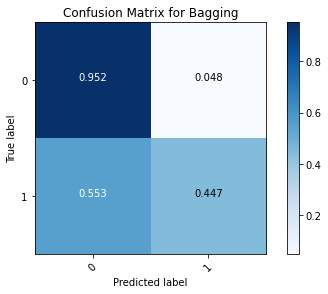

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

classes = [0,1]
y_true = y_test
y_pred = vote(classifiers, x_test)
cm = confusion_matrix(y_true, y_pred, normalize ='true')

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix for Bagging")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3), horizontalalignment="center", color="white" if cm[i, j] > 0.5 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [14]:
import sklearn
accuracy = sum(y_pred == y_true)/ len(y_pred)
recall_score = sklearn.metrics.recall_score( y_true, y_pred) 
precision_score = sklearn.metrics.precision_score(y_true, y_pred) 

print("\nAccuracy on testing set: {:.4f} %".format(accuracy*100))
print("Presicion on testing set:", precision_score)
print("Recall on testing set:", recall_score)


Accuracy on testing set: 86.4300 %
Presicion on testing set: 0.6615515771526002
Recall on testing set: 0.4470046082949309
